# PEST setup of MIKE SHE model with mikecalsetup and pyEMU


Parameters reside in many different file formats in MIKE SHE. The \*.she, \*.mhydro, \*.uzs and \*.etv files are formatted as nested headers and parameters in these files can be parameterized by mikecalsetup. The \*.dfs files are binary data files for handling spatially distributed and time dependent data (https://docs.mikepoweredbydhi.com/core_libraries/dfs/dfs-file-system/). Other python tools already exists that can parameterize such files, and mikecalsetup is therefore not designed to do so. 

The PstFrom module of pyEMU is super advanced tool for setting up PEST files and can, among other things, create pilot point, zonation and grid parameterizations of arrays and table files (https://github.com/pypest/pyemu). To apply PstFrom to MIKE SHE input files, the input files have to be converted into a text file format. This can be easily achieved through MIKE IO (https://github.com/DHI/mikeio).

In this example, we combine the PEST setups which can be created by mikecalsetup and pyEMU.

In [1]:
import os
import mikeio
import numpy as np
import pandas as pd
import shutil
import pyemu
import matplotlib.pyplot as plt
import mikecalsetup

# mikecalsetup 
First we create a PEST setup of an example MIKE SHE model using mikecalsetup. We save the extracted par_file dataframe to a new variable and pass an empty dataframe back to the setup. This dataframe contains the names and paths to input files for the MIKE SHE setup. We want PstFrom to parameterize these and not mikecalsetup (therefore the empty dataframe) because the former has much more sophisticated methods.

In [2]:
os.chdir('../test')
mod_nme = 'Karup_basic_pest'  # name of model (no extension),
pth = './example_models/Karup/Karup_Basic'  # relative path to model
setup = mikecalsetup.Setup(mod_nme, pth)
setup.program = 'PEST'
par_file = setup.par_files.copy()
setup.par_files = pd.DataFrame()
setup.write_files()

We can already now load our mikecalsetup genereated PEST setup with pyEMU (but this is not necessary).

In [3]:
# loading mikecalsetup generated PEST setup
# pst = pyemu.Pst('Karup_basic_pest.pst')

# PstFrom setup
We will use the generated template and instruction files generated by mikecalsetup later. However, first we will create another PEST setup using PstFrom module of pyEMU. We start by creating a PstFrom object, which will also copying our model setup to a new folder.

In [4]:
# generate a PstFrom object (will copy model directory to new folder template_ws)
template_ws = './pest_setup'
pf = pyemu.utils.PstFrom(original_d=pth, new_d=template_ws, remove_existing=True)

2023-08-10 15:11:02.803106 starting: opening PstFrom.log for logging
2023-08-10 15:11:02.804099 starting PstFrom process
2023-08-10 15:11:02.804099 starting: setting up dirs
2023-08-10 15:11:02.805093 starting: removing existing new_d 'pest_setup'
2023-08-10 15:11:03.298520 finished: removing existing new_d 'pest_setup' took: 0:00:00.493427
2023-08-10 15:11:03.299521 starting: copying original_d 'example_models\Karup\Karup_Basic' to new_d 'pest_setup'
2023-08-10 15:11:17.753812 finished: copying original_d 'example_models\Karup\Karup_Basic' to new_d 'pest_setup' took: 0:00:14.454291
2023-08-10 15:11:17.756984 finished: setting up dirs took: 0:00:14.952885


## Parameterizing dfs files
Say we want to parameterize the root depth using PstFrom. The root depth is currently in a dfs file format, which is not supported by PstFrom.

<Axes: xlabel='Easting [m]', ylabel='Northing [m]'>

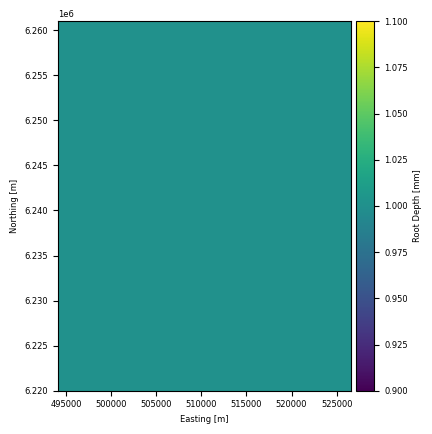

In [5]:
# update the file paths to the working directory
par_file_df = par_file.copy()
par_file_df['file'] = par_file_df['file'].apply(lambda x: x.replace('\\', '/').replace(pth, '')[1:])
# select file to parameterize
nme = 'lu_RD_arrfile'
arrfile = par_file_df.loc[nme, 'file']
arritem = par_file_df.loc[nme, 'item']
arrfile
mikeio.read(os.path.join(template_ws, arrfile))[int(arritem-1)].plot()

To parameterize this file we will therefore have to:
1. Convert dfs2 file to array txt file readable by PstFrom.
2. Parameterize created txt file with PstFrom.
3. Develop preprocessing script converting txt file back to dfs2 file format.
4. Finally add the generated preprocessing script to forward_run file (generated by PstFrom).


### 1. Dfs2 to txt arritem
The following function will save the values of the dfs file as a txt file. 

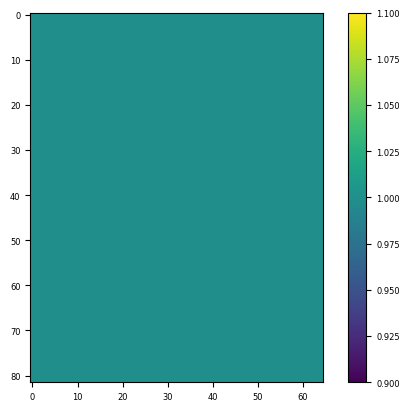

In [6]:
def dfs2_to_txt(file, item):
    """Convert dfs2 file to txt file."""
    # loading file
    ds = mikeio.read(file)[int(item-1)]

    # saving file
    np.savetxt(file + '.txt', ds.values[0, :, :])


# apply the created function
dfs2_to_txt(os.path.join(template_ws, arrfile), arritem)

# loading and inspecting new file
txt_array = np.loadtxt(os.path.join(template_ws, arrfile)+ '.txt')
c = plt.imshow(txt_array)
plt.colorbar(c)

Note, the geometry or time which is also stored in the dfs file, will not be represented in the txt file. When converting the txt file back to the dfs file, we will have to load the original file to access this information.

### 2. Parameterize file with PstFrom
Within PstFrom, options for parameterization of the txt file include constant, zonation, pilot points and grid. The reader is referred to the documentation of PstFrom. In this example we will just use the simplest constant parameterization type. The following command will create a template file and other useful files to parameterize the root depth array.

In [7]:
pf.add_parameters(
    filenames=os.path.normpath(arrfile + '.txt'), par_type="constant",
    par_name_base="rd", pargp="rd")

2023-08-10 15:11:20.103457 transform was not passed, setting default tranform to 'log'
2023-08-10 15:11:20.105645 starting: adding constant type m style parameters for file(s) ['Model_Inputs\\Root Depth.dfs2.txt']
2023-08-10 15:11:20.105645 starting: loading array pest_setup\Model_Inputs\Root Depth.dfs2.txt
2023-08-10 15:11:20.114694 finished: loading array pest_setup\Model_Inputs\Root Depth.dfs2.txt took: 0:00:00.009049
2023-08-10 15:11:20.114694 loaded array 'example_models\Karup\Karup_Basic\Model_Inputs\Root Depth.dfs2.txt' of shape (82, 65)
2023-08-10 15:11:20.137583 starting: writing array-style template file 'pest_setup\rd_inst0_constant.csv.tpl'
2023-08-10 15:11:20.137583 starting: writing template file pest_setup\rd_inst0_constant.csv.tpl for ['rd_inst:0']
2023-08-10 15:11:20.218692 finished: writing template file pest_setup\rd_inst0_constant.csv.tpl for ['rd_inst:0'] took: 0:00:00.081109
2023-08-10 15:11:20.218692 starting: writing array-based template file 'pest_setup\rd_inst

,parnme,parval1,pargp,tpl_filename,input_filename,partype,partrans,parubnd,parlbnd,parchglim,offset,scale,dercom
pname:rd_inst:0_ptype:cn_pstyle:m,pname:rd_inst:0_ptype:cn_pstyle:m,1.0,rd,pest_setup\rd_inst0_constant.csv.tpl,pest_setup\mult\rd_inst0_constant.csv,constant,log,1.000000e+10,1.000000e-10,factor,0.0,1.0,1


The output is a dataframe with a single constant parameter for the root depth.

### 3. Preprocessing script
The preprocessing script will include a definition of a function converting the txt file back into a dfs file and another function applying the former function on the array. The function is defined as:

In [8]:
function_name = 'txt_to_dfs2'
def txt_to_dfs2(file, item):
    """Convert txt file to dfs2 file."""
    # load old array to get geometry
    ds = mikeio.read(file)
    # load new values
    arr2d = np.loadtxt(file + '.txt')
    # assign values and save
    arr3d = np.expand_dims(arr2d, axis=0)
    ds[int(item-1)].values = arr3d
    ds.to_dfs(file)

This function is saved in the pst_helper_functions.py script in the current directory. We will copy it from here to include in the new script.

In [1]:
with open('../examples/pst_helper_functions.py', 'r') as file:
    lines = file.readlines()
func_lines = lines[19:31]
func_lines

['def txt_to_dfs2(file, item):\n',
 '    """Convert txt file to dfs2 file."""\n',
 '    # load old array to get geometry\n',
 '    ds = mikeio.read(file)\n',
 '    # load new values\n',
 "    arr2d = np.loadtxt(file + '.txt')\n",
 '    # assign values and save\n',
 '    arr3d = np.expand_dims(arr2d, axis=0)\n',
 '    ds[int(item-1)].values = arr3d\n',
 '    ds.to_dfs(file)\n',
 '\n']

We will save this function to a preprocessing script. Further, we will apply the function to our current example to convert the root depth txt file back to a dfs2 file.

In [10]:
with open('pre_proc_files.py', 'w') as file:
    file.write('import numpy as np\n\n')
    file.write('def preproc():\n')
    # defining the txt_to_dfs2 function
    file.writelines([' '*4 + line for line in func_lines])
    # applying the above function to root depth example
    file.write(' '*4+function_name + '(file="'+arrfile+'", item={:d})'.format(arritem))

In [11]:
# inspecting the create pre proceessing file
with open('pre_proc_files.py', 'r') as file:
    lines = file.readlines()
lines

['import numpy as np\n',
 '\n',
 'def preproc():\n',
 '    def txt_to_dfs2(file, item):\n',
 '        """Convert txt file to dfs2 file."""\n',
 '        import mikeio\n',
 '        # load old array to get geometry\n',
 '        ds = mikeio.read(file)\n',
 '        # load new values\n',
 "        arr2d = np.loadtxt(file + '.txt')\n",
 '        # assign values and save\n',
 '        arr3d = np.expand_dims(arr2d, axis=0)\n',
 '        ds[int(item-1)].values = arr3d\n',
 '        ds.to_dfs(file)\n',
 '    \n',
 '    txt_to_dfs2(file="Model_Inputs/Root Depth.dfs2", item=1)']

### 4. Add preprocessing script to forward model run
PstFrom contains a super simple function to add functions to the forward script and takes care of the rest.

In [12]:
pf.add_py_function("pre_proc_files.py",  # the file which contains the function
                   "preproc()",  # the function, making sure to specify any arguments it may require
                   is_pre_cmd=True)

## Forward model
Now the forward model will include a preprocessing step that converts the txt file back into the dfs file format read by MIKE SHE. 

The forward model run by PEST, should also include:
1. command to run MIKE SHE
2. command to calculate statistics

Both these steps have been included in the bat file "forward.bat" generated by mikecalsetup. "forward.bat" can therefore be run in forward_run.py script which will be generated by pst_from (forward model option 1). To do this, we just have to take care of the relative paths in the bat file:

In [13]:
# with open('forward.bat', 'r') as file:
#     content = file.read()
#     content = content.replace(pth, '')
# with open(os.path.join(template_ws, 'forward.bat'), 'w') as file:
#     file.write(content)

Alternatively to running "forward.bat",  the postprocessing step and model run can be added seperately (forward model option 2). Here we add the postprocessing step.

In [14]:
# add post processing step from generated script in mikecalsetup
pf.add_py_function("stats_ed.py",  # the file which contains the function
                   "calculate_stats()",  # the function, making sure to specify any arguments it may require
                   is_pre_cmd=False)

In both cases, we need to add the command to run MIKE SHE to the forward_run script. Here we make a placeholder that we will replace later.
(This workaround is necessary as pyemu os utils run adds an '.exe' suffix to the string).

In [15]:
# add indicatorto the forward_run.py script for replcement later.
indicator = 'RUN_MIKE_SHE_HERE'
pf.mod_sys_cmds.append(indicator)

Finally build the pest setup from PstFrom. We will also add a few imports of python packages that we are using in the added pre- and postprocessing steps.

In [16]:
pf.extra_py_imports.append('time')
pf.extra_py_imports.append('mikeio')
pf.extra_py_imports.append('mikecalsetup.stats_def as stats_def')
pst = pf.build_pst()

noptmax:0, npar_adj:1, nnz_obs:0
2023-08-10 15:11:20.740189 forward_run line:pyemu.os_utils.run(r'RUN_MIKE_SHE_HERE')



C:\Users\wqg436\Anaconda3\envs\mike\Lib\site-packages\pyemu\pst\pst_handler.py:1618: PyemuWarning: no non-zero weight obs


pyEMU has now generated a PEST setup that includes a single parameter for root depth. We have not added added any observations and pyEMU therefore throws a warning.

# Adding information generated by mikecalsetup (using ins and tpl files)
Now that we have used PstFrom to generate a parameter for an array, we can combine it with the setup generated by mikecalsetup by using pyEMU.

We will:
1. Add observations by using the mikecalsetup generated ".ins" fil
2. Add parameters by using the mikecalsetup generated ".tpl" file
3. Modify the PstFrom generated forward_run.py file. 


## Observations
Copying the postprocessing script 'stats.py' and the instruction file into the new working folder. Finally, add the observations through pyEMU.

In [17]:
# Observations
shutil.copy("stats.py", os.path.join(template_ws, "stats.py"))
shutil.copy("stats.txt.ins", os.path.join(template_ws, "stats.txt.ins"))
pst.add_observations(os.path.join(template_ws, "stats.txt.ins"), pst_path=".")  # add observations from instruction file

# take care of file paths for statistics
res_df = pd.read_csv('sim_vs_obs.csv')
res_df['sim_file'] = res_df['sim_file'].apply(lambda x: x.replace('\\', '/').replace(pth, '')[1:])
res_df['obs_file'] = res_df['obs_file'].apply(lambda x: x.replace('\\', '/').replace(pth[2:], '')[1:])
res_df.to_csv(os.path.join(template_ws, 'sim_vs_obs.csv'))

error processing instruction/output file pair: output file './pest_setup\.\stats.txt' not found
8 obs added from instruction file ./pest_setup\.\stats.txt.ins


## Parameters


In [18]:
# Parameters
infiles = setup.files  # input files
infiles = ['.'+file.replace(pth, '') for file in infiles]  # take care of relative paths
tplfiles = [os.path.splitext(file)[0] + '.tpl' for file in infiles]  # template files

for i in range(len(tplfiles)):
    # pyemu will delete path to file so specify in pst_path in the add_parameters function
    path = os.path.normpath(tplfiles[i])
    path = path.split(os.sep)
    path = '.' if len(path) == 1 else path[0]
    # add parameters from template file
    pst.add_parameters(os.path.join(template_ws, tplfiles[i]),
                       in_file=infiles[i], pst_path=path)

# set initial values as extracted by mikecalsetup (automatically set as 1 in pyemu)
par = pst.parameter_data  # pyemu generated parameter table
mcs_par = setup.par  # mikecalsetup generated parameter table
mcs_par.index = mcs_par.index.str.lower()  # rename index to match that generated by pyEMU
par['parval1'] = mcs_par['value']  # set values
par['parval1'] = par['parval1'].fillna(0.2)  # new generated values by Pst_From

# write final setup to file
pst.write(os.path.join(template_ws, "new.pst"))

11 pars added from template file .\Karup_basic_pest.tpl
6 pars added from template file Model_Inputs\UNSODA_basic_soil_classes.tpl
noptmax:0, npar_adj:18, nnz_obs:8


## Forward run
PstFrom generated a forward_run script. Ealier we added the indicator 'RUN_MIKE_SHE_HERE' which we will replace here. 

In [19]:
forward_run_script = os.path.join(template_ws, 'forward_run.py')
with open(forward_run_script, 'r') as file:
    lines = file.readlines()
idx = [i for i, line in enumerate(lines) if indicator in line][0]  # locate substring indicator

# replace call (forward model option 1: use forward.bat file that includes both model call + postprocessing step)
# lines[idx] = "    os.system('forward.bat')"

# replace call (forward model option 2: seperate model call and postprocessing step)
exe = 'cmd /c"' + setup.mzpath+'\\MzLaunch.exe"'
lines[idx] = "    os.system('" + exe + ' ' + setup.mod_nme + ".she -x')\n"
lines[idx] = lines[idx].replace('\\', '\\\\')
lines.insert(idx, '    time.sleep(2)\n')  # adding some pause (before model call)
lines.insert(idx+2, '    time.sleep(15)\n')  # adding some pause (after model call). Note: shorter pause may work when not running from jupyter notebook

# write lines back to file
with open(forward_run_script, 'w') as file:
    file.writelines(lines)

# Running PEST
We have now combined the PEST setups. Let's run PEST (noptmax == 0) and see if it works.

(To run, you will need to download PEST (https://pesthomepage.org/programs). When downloaded, copy pestpp-glm into the file folder template_ws).

In [21]:
pyemu.helpers.run("pestpp-glm new.pst", cwd=template_ws)

### Test that PEST ran succesfully

In [23]:
# Test that PEST ran succesfully
with open(os.path.join(template_ws, 'new.rec'), 'r') as file:
    lines = file.readlines()
lines[-1] == 'Number of forward model runs performed during optimization: 1\n'

True

In [24]:
# Test that value has been updated (should be 0.2 as set by pest control file)
ds = mikeio.read(os.path.join(template_ws, arrfile))[int(arritem-1)]
ds.values

array([[[0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
        [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
        [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
        ...,
        [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
        [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
        [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2]]], dtype=float32)

### Troubleshooting
Note, if PEST does not run but:

In [25]:
# .... MIKE SHE ran succesfully
with open(os.path.join(template_ws, 'Karup_basic_pest.log'), 'r') as file:
    print('Simulation succeeded' in file.read())
# ... but stat file is empty
print(os.stat(os.path.join(template_ws, 'stats.txt')).st_size == 0)

False
False


Try adding more pause after model call in the forward_run.py script.